In [1]:
# for math operations
import pandas as pd
import numpy as np

# for data preprocessing
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Model building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
import pickle

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords')
stemmer = PorterStemmer()
words = stopwords.words("english")

%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# POS TAGGER USING CRF



In [2]:
import nltk
nltk.download('treebank')
tagged_sentences = nltk.corpus.treebank.tagged_sents()

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [3]:
def features(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:]
    }

In [4]:
from nltk.tag.util import untag

# Split the dataset for training and testing
cutoff = int(.75 * len(tagged_sentences))
training_sentences = tagged_sentences[:cutoff]
test_sentences = tagged_sentences[cutoff:]

def transform_to_dataset(tagged_sentences):
    X, y = [], []

    for tagged in tagged_sentences:
        X.append([features(untag(tagged), index) for index in range(len(tagged))])
        y.append([tag for _, tag in tagged])

    return X, y

X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(test_sentences)

In [47]:
#pip install sklearn-crfsuite


In [48]:
#pip install -U 'scikit-learn<0.24'

In [5]:
from sklearn_crfsuite import CRF

modelCRF = CRF(algorithm='lbfgs', c1=0.1,c2=0.1,max_iterations=100,all_possible_transitions=True)
save_model = modelCRF.fit(X_train, y_train)

with open('CRF.pickle', 'wb') as f:
  pickle.dump(save_model, f)

# Load model if exist

In [67]:
modelCRF = pickle.load(open('CRF.pickle', 'rb'))

In [6]:
import pandas as pd
train = pd.read_csv('../datasets/BBC-News-Train.csv')
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [7]:
import nltk
from nltk.corpus import reuters,brown
nltk.download('reuters')
nltk.download('brown')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
from nltk import word_tokenize
from nltk.tag import untag

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [8]:

def get_POS():
  DF = pd.DataFrame(columns=['Text', 'Category'])
  for i in range(len(train)):
    sentence = word_tokenize(train['Text'][i])
    category = train['Category'][i]
    sentence_features = [features(sentence, index) for index in range(len(sentence))]
    res=[]
    pos_tag = modelCRF.predict([sentence_features])
    for k in range(len(sentence)):
      tag = pos_tag[0][k]
      if tag == 'NN':
        res.append(sentence[k])
    str = ' '.join(set(res))
    DF.loc[i] =[str, category]
  return DF

In [9]:
trainEmail = get_POS()

trainEmail.to_pickle('EmailDataFrame.pickle')

# Load Email dataframe if exist

In [68]:
trainEmail = pd.read_pickle('EmailDataFrame.pickle')

In [10]:
def pos_tag(sentence):
    sentence_features = [features(sentence, index) for index in range(len(sentence))]
    return list(zip(sentence, modelCRF.predict([sentence_features])[0]))

In [11]:
print(pos_tag(word_tokenize("a")))

[('a', 'DT')]


# EMAIL CLASSIFICATION

In [42]:
trainCate = trainEmail[['Text','Category']]
trainCate.Category.unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [13]:
stemmer = PorterStemmer()
words = stopwords.words("english")

trainCate['Text'] = trainCate['Text'].apply(
    lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

In [14]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(trainCate['Text']).toarray()
final_features.shape

(1490, 7608)

In [15]:
#first we split our dataset into testing and training set:
# this block is to split the dataset into training and testing set 
X = trainCate['Text']
Y = trainCate['Category']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# instead of doing these steps one at a time, we can use a pipeline to complete them all at once
pipeline = Pipeline([('vect', vectorizer),
                    ('chi',  SelectKBest(chi2, k=1200)),
                    ('clf', RandomForestClassifier())])

# fitting our model and save it in a pickle for later use
model = pipeline.fit(X_train, y_train)
with open('DomainPredictionModel.pickle', 'wb') as f:
  pickle.dump(model, f)


In [70]:
model = pickle.load(open('DomainPredictionModel.pickle', 'rb'))

In [18]:
ytest = np.array(y_test)
  
# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

               precision    recall  f1-score   support

     business       0.85      0.97      0.91        64
entertainment       0.97      0.89      0.93        63
     politics       0.98      0.88      0.93        51
        sport       0.94      1.00      0.97        72
         tech       0.98      0.90      0.93        48

     accuracy                           0.93       298
    macro avg       0.94      0.93      0.93       298
 weighted avg       0.94      0.93      0.93       298

[[62  0  0  1  1]
 [ 3 56  1  3  0]
 [ 5  1 45  0  0]
 [ 0  0  0 72  0]
 [ 3  1  0  1 43]]


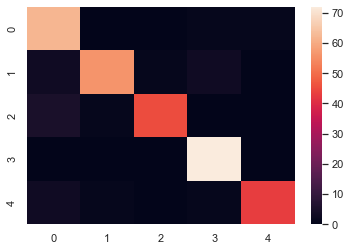

In [45]:
import seaborn as sns
sns.set()
axe = sns.heatmap(confusion_matrix(ytest, model.predict(X_test)))
plt.show()

# Predict email's domain

Load legit mail from folder

In [19]:
def cleanText(str):
  return ' '.join(re.sub('[^A-Za-z ]+', '', str.lower()).split()).replace('subject', '').strip()

In [24]:
def preprocessText(str):
  return ' '.join([stemmer.stem(i) for i in re.sub('[^a-zA-Z]', ' ', str).split() if i not in words])

In [39]:
def selectOnlyNouns(emails):
  noun_only_emails = []
  for mail in emails:
    sentence = word_tokenize(mail)
    sentence_features = [features(sentence, index) for index in range(len(sentence))]
    res=[]
    pos_tag = modelCRF.predict([sentence_features])
    for k in range(len(sentence)):
      tag = pos_tag[0][k]
      if tag == 'NN':
        res.append(sentence[k])
    str = ' '.join(set(res))
    noun_only_emails.append(str)
  return noun_only_emails

In [25]:
mails_to_classify = []
mail_names = []
ham_path = '../datasets/non-spam'

for file_name in os.listdir(ham_path):
  with open(os.path.join(ham_path, file_name), 'r', encoding='utf8') as f:
    text = preprocessText(cleanText(f.read()))
    if text:
      mails_to_classify.append(text)
      mail_names.append(file_name)

In [40]:
def Main():
  predDomain = model.predict(mails_to_classify)
  for i in range(len(mail_names)):
    print("Email {} - {} domain".format(mail_names[i], predDomain[i]))
  # print("POS TAGGER:")
  # print(pos_tag(word_tokenize(message)))

In [41]:
Main()

Email 0049.2001-04-06.williams.ham.txt - business domain
Email 0053.2001-04-07.williams.ham.txt - sport domain
Email 0063.2001-02-23.kitchen.ham.txt - business domain
Email 0065.2001-02-23.kitchen.ham.txt - business domain
Email 0314.2000-02-19.beck.ham.txt - business domain
Email 0317.2000-02-20.beck.ham.txt - sport domain
Email 0324.2000-02-20.beck.ham.txt - business domain
Email 0327.2001-05-03.williams.ham.txt - sport domain
Email 0481.2000-07-21.lokay.ham.txt - tech domain
Email 0484.2000-07-21.lokay.ham.txt - tech domain
Email 0491.2000-07-21.lokay.ham.txt - business domain
